# Загрузка Order book из CSV

In [91]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
#from sklearn.cross_validation import cross_val_score
#from sklearn.cross_validation import cross_val_predict
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from alex.database import Database
from pprint import pprint
from statsmodels.tsa.stattools import adfuller # Расширенный тест Дики-Фуллера
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot

### Скоростная загрузка с диска, из заархивированного CSV-файла

In [92]:
# результат выполнения запроса:
# select * from tvf_get_order_book_snapshots(2880) where exchange='binance' and pair='ETH/USDT' # запрос на 20 минут
#order = pd.read_csv('tvf_get_order_book_snapshots 15.09.2018-01.10.2018.zip', index_col='dt')

In [93]:
# загрузка истории
# 15 секунд
db = Database()
sql_history = f"select * from v_history where exchange='binance' and pair='ETH/USDT' and dt>'2018-07-01'"
df_history = db.query(sql_history)
df_history.set_index('dt', inplace=True)

In [94]:
df_history.shape

(4318228, 11)

In [95]:
df_history.sort_values('dt').head()

,rownum,id_ex_pair,exchange,pair,price,amount,type,side,id,location,insert_date
dt,,,,,,,,,,,
2018-08-07 03:18:34,NaN,19,binance,ETH/USDT,406.630005,0.03000,None,buy,NaN,disk,2018-09-07 02:20:10.6200000
2018-08-07 03:18:34,NaN,19,binance,ETH/USDT,406.399994,3.50655,None,sell,NaN,disk,2018-09-07 02:20:10.6200000
2018-08-07 03:18:41,NaN,19,binance,ETH/USDT,406.329987,4.31794,None,sell,NaN,disk,2018-09-07 02:20:10.6200000
2018-08-07 03:18:41,NaN,19,binance,ETH/USDT,406.470001,6.13147,None,buy,NaN,disk,2018-09-07 02:20:10.6200000
2018-08-07 03:18:42,NaN,19,binance,ETH/USDT,406.609985,1.71500,None,buy,NaN,disk,2018-09-07 02:20:10.6200000


In [96]:
# Добавление даты номера недели и дня недели

df_history.reset_index(inplace=True)
df_history['time'] = pd.to_datetime(df_history.dt)
df_history['weekno'] = df_history.time.dt.weekofyear
df_history['dayweek'] = df_history.time.dt.weekday
#df_history.head()

# Формирование нового датафрейма w, где средняя цена, сгрупированная по неделям и дням недели
w=df_history.groupby(['weekno','dayweek'])[['price']].mean()#.to_excel('dayofweek.xlsx')#(#.pct_change().plot(kind='bar')

# добавление поля ks (коэф.сез.) - средняя цена дня делится на среднюю цену недели, к которой этот день принадлежит
w['ks'] = w.price / w.groupby('weekno').price.mean()
w.reset_index(inplace=True)

# расчет корреляции между номером дня недели и "коэф.сезонности" данного дня
w.ks.corr(w.dayweek)

-0.19252577398340825

In [97]:
w.groupby(['dayweek', 'weekno']).ks.mean()#.to_excel('dayofweek.xlsx

dayweek  weekno
0        33        1.067793
         34        1.052075
         35        0.964350
         36        1.188315
         37        0.974160
         38        0.965596
         39        1.056987
         40        1.021766
         41        1.071062
         42        1.022451
1        32        1.148307
         33        0.907276
         34        0.993292
         35        1.002356
         36        1.179454
         37        0.941070
         38        0.903840
         39        0.955149
         40        1.015972
         41        1.079160
         42        1.006717
2        32        1.023922
         33        0.967852
         34        1.012529
         35        1.022643
         36        1.102038
         37        0.871375
         38        0.940611
         39        0.959756
         40        0.981631
                     ...   
4        33        1.011358
         34        0.985978
         35        0.982504
         36        0.915435
    

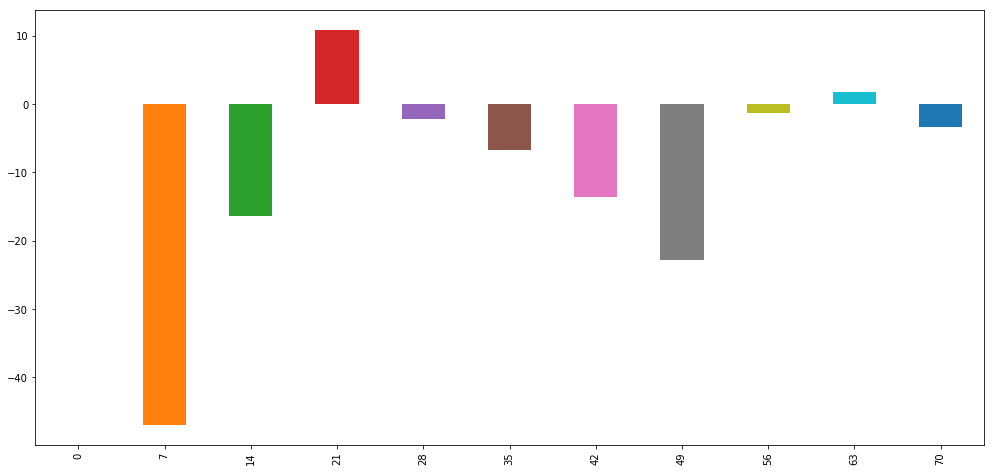

In [98]:
# поиск дня недели, в котором бы чаще наблюдалось падение или рост по сравнению с предыдущим днем 

wd = w.groupby(['weekno', 'dayweek'])[['price']].mean().diff()
wd.reset_index(inplace=True)
_=wd[wd.dayweek ==1].price.plot(kind='bar', figsize=(17,8))
#wd.to_excel('dayofweek.xlsx')

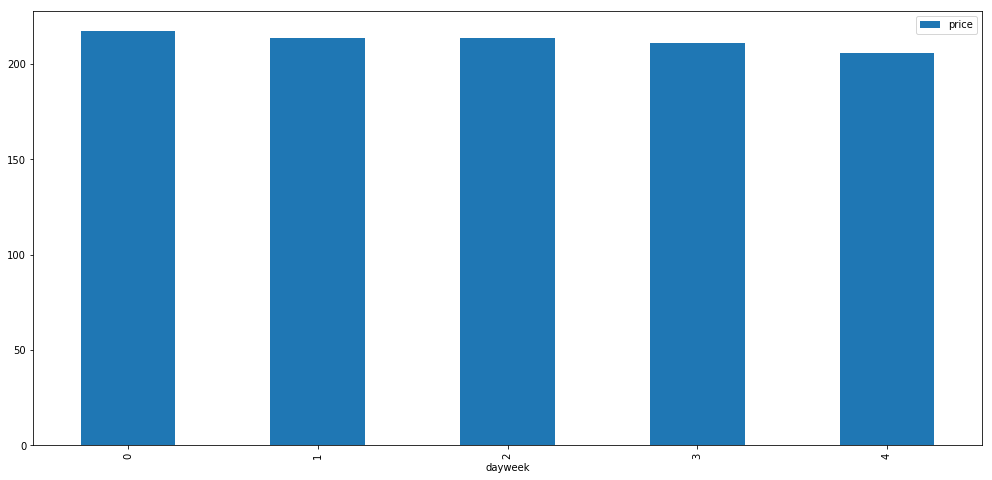

In [99]:
_=w[w.weekno==42][['dayweek','price']].set_index('dayweek').plot(kind='bar', figsize=(17,8))

In [131]:
df_history['day'], df_history['hour'], df_history['month'] = df_history.time.dt.day, df_history.time.dt.hour,df_history.time.dt.month
#df_history['hour'] = df_history.time.dt.hour

In [132]:
df_history.head()

,dt,level_0,index,rownum,id_ex_pair,exchange,pair,price,amount,type,side,id,location,insert_date,time,weekno,dayweek,day,hour,month
0,2018-10-03 05:48:29,0,0,8153396.0,19,binance,ETH/USDT,220.889999,0.10399,None,sell,38408575.0,memory,2018-10-03 05:48:32.0133333,2018-10-03 05:48:29,40,2,3,5,10
1,2018-10-03 05:48:30,1,1,8153399.0,19,binance,ETH/USDT,220.889999,1.20063,None,sell,38408577.0,memory,2018-10-03 05:48:32.0133333,2018-10-03 05:48:30,40,2,3,5,10
2,2018-10-03 05:48:30,2,2,8153397.0,19,binance,ETH/USDT,220.889999,0.10399,None,buy,38408579.0,memory,2018-10-03 05:48:32.0133333,2018-10-03 05:48:30,40,2,3,5,10
3,2018-10-03 05:48:30,3,3,8153398.0,19,binance,ETH/USDT,220.889999,0.35762,None,sell,38408578.0,memory,2018-10-03 05:48:32.0133333,2018-10-03 05:48:30,40,2,3,5,10
4,2018-10-03 05:48:30,4,4,8153403.0,19,binance,ETH/USDT,220.949997,7.89601,None,buy,38408582.0,memory,2018-10-03 05:48:32.0133333,2018-10-03 05:48:30,40,2,3,5,10


In [135]:
df_history.reset_index(inplace=True)


In [136]:
dh = df_history

In [137]:
dh.groupby(['month','day', 'hour'])[['price']].mean()

price
month day hour            
8     7   3     406.501000
          4     405.592896
          14    409.520501
          15    409.764101
      8   13    368.096902
          16    366.216700
          17    362.883902
          20    357.469797
      9   0     355.638947
          1     354.093900
          2     354.894900
          3     356.416101
          4     356.979498
          5     359.636299
          6     358.230400
          7     360.005999
          8     360.351098
          9     361.096098
          10    359.401402
          11    359.516901
          12    360.020305
          13    359.463401
          14    357.562900
          15    354.647599
          16    354.720499
          17    362.427201
          18    362.305199
          19    363.468200
          20    363.100000
          21    362.411100
...                    ...
10    18  3     212.805286
          4     212.840030
          5     213.041396
          6     214.336789
          7     213.999772
          8     213.358437
          9     213.124599
          10    213.121046
          11    211.890827
          12    212.305409
          13    212.247490
          14    211.585157
          15    211.379462
          16    211.109526
          17    210.904709
          18    208.837964
          19    209.057644
          20    206.875898
          21    206.378147
          22    205.789031
          23    206.431049
      19  0     205.001732
          1     204.974941
          2     206.307592
          3     206.828169
          4     206.329129
          5     206.163449
          6     206.325063
          7     206.644149
          8     206.030819

[1721 rows x 1 columns]

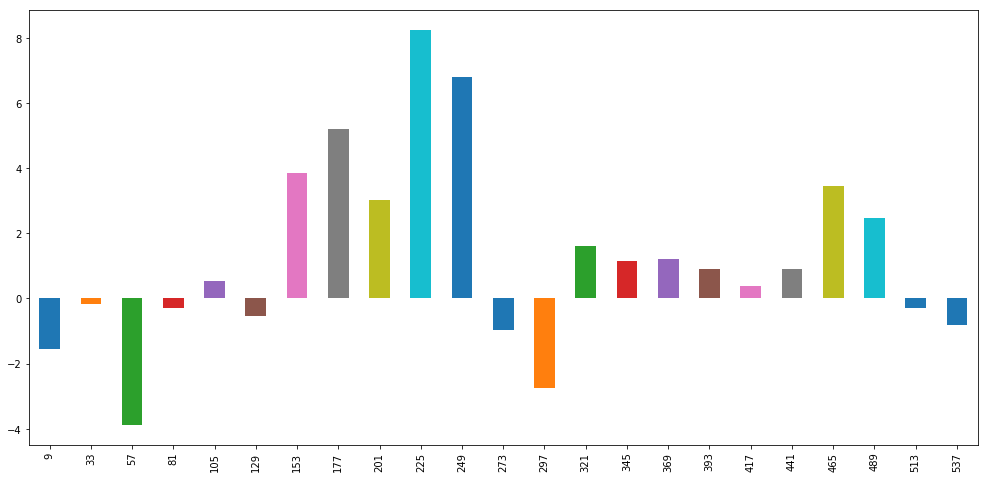

In [172]:
d = dh.groupby(['month','day','hour'])[['price']].mean().diff()
d.reset_index(inplace=True)
_=d[(d.month == 8) & (d.hour == 1)].price.plot(kind='bar', figsize=(17,8))

In [173]:
month_no = 8

for hour_no in range(24):
    print(len(d[(d.month == month_no) & (d.hour == hour_no) & (d.price > 0)])/len(d[(d.month == month_no) & (d.hour == hour_no)]))
    print(hour_no)

0.391304347826087
0
0.6086956521739131
1
0.5217391304347826
2
0.5
3
0.5416666666666666
4
0.34782608695652173
5
0.6521739130434783
6
0.43478260869565216
7
0.5217391304347826
8
0.5217391304347826
9
0.4782608695652174
10
0.6086956521739131
11
0.5217391304347826
12
0.5
13
0.5833333333333334
14
0.5416666666666666
15
0.5416666666666666
16
0.3333333333333333
17
0.4782608695652174
18
0.5217391304347826
19
0.4583333333333333
20
0.30434782608695654
21
0.5652173913043478
22
0.391304347826087
23
